In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-drone-dataset/class_dict_seg.csv
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/173.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/491.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/043.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/248.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/038.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/480.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/236.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/083.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/513.png
/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_da

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMAGE_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [4]:
n_classes = 23 

def create_dataframe():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
            
    return pd.DataFrame({'id':name}, index= np.arange(0, len(name)))

df = create_dataframe()

In [5]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

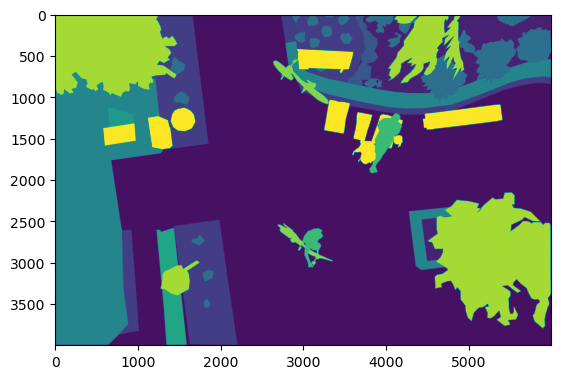

(4000, 6000, 3)
(4000, 6000)


In [6]:
for idx in X_val:
    img = Image.open(IMAGE_PATH + idx + '.jpg')
    mask = Image.open(MASK_PATH + idx + '.png')
    #plt.imshow(img)
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

# Create Dataset class

In [8]:
class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx]+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx]+'.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask = mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patch:
            img, mask = self.tiles(img, mask)
        
        return img, mask
    
    def tiles(img, mask):
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
        

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = Drone_data(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 6 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [10]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 77.1MB/s]


In [11]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [12]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [13]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [14]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.924 
Epoch:1/15.. Train Loss: 2.617.. Val Loss: 1.924.. Train mIoU:0.042.. Val mIoU: 0.086.. Train Acc:0.330.. Val Acc:0.546.. Time: 4.39m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.924 >> 1.422 
Epoch:2/15.. Train Loss: 1.880.. Val Loss: 1.422.. Train mIoU:0.092.. Val mIoU: 0.138.. Train Acc:0.567.. Val Acc:0.675.. Time: 3.86m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.422 >> 1.106 
Epoch:3/15.. Train Loss: 1.424.. Val Loss: 1.106.. Train mIoU:0.120.. Val mIoU: 0.141.. Train Acc:0.621.. Val Acc:0.692.. Time: 3.96m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.106 >> 1.053 
saving model...
Epoch:4/15.. Train Loss: 1.239.. Val Loss: 1.053.. Train mIoU:0.156.. Val mIoU: 0.163.. Train Acc:0.655.. Val Acc:0.693.. Time: 3.93m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/15.. Train Loss: 1.134.. Val Loss: 1.191.. Train mIoU:0.171.. Val mIoU: 0.164.. Train Acc:0.676.. Val Acc:0.670.. Time: 3.95m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 1.191 >> 0.864 
Epoch:6/15.. Train Loss: 1.044.. Val Loss: 0.864.. Train mIoU:0.180.. Val mIoU: 0.196.. Train Acc:0.695.. Val Acc:0.744.. Time: 3.99m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.864 >> 0.763 
Epoch:7/15.. Train Loss: 0.959.. Val Loss: 0.763.. Train mIoU:0.199.. Val mIoU: 0.211.. Train Acc:0.720.. Val Acc:0.774.. Time: 3.90m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/15.. Train Loss: 0.855.. Val Loss: 0.818.. Train mIoU:0.220.. Val mIoU: 0.209.. Train Acc:0.750.. Val Acc:0.756.. Time: 3.84m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.818 >> 0.703 
Epoch:9/15.. Train Loss: 0.856.. Val Loss: 0.703.. Train mIoU:0.224.. Val mIoU: 0.231.. Train Acc:0.744.. Val Acc:0.791.. Time: 3.94m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.703 >> 0.671 
Epoch:10/15.. Train Loss: 0.788.. Val Loss: 0.671.. Train mIoU:0.245.. Val mIoU: 0.245.. Train Acc:0.767.. Val Acc:0.795.. Time: 3.98m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.671 >> 0.621 
saving model...
Epoch:11/15.. Train Loss: 0.711.. Val Loss: 0.621.. Train mIoU:0.267.. Val mIoU: 0.295.. Train Acc:0.788.. Val Acc:0.819.. Time: 3.90m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.621 >> 0.594 
Epoch:12/15.. Train Loss: 0.714.. Val Loss: 0.594.. Train mIoU:0.285.. Val mIoU: 0.303.. Train Acc:0.785.. Val Acc:0.825.. Time: 3.88m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.594 >> 0.576 
Epoch:13/15.. Train Loss: 0.627.. Val Loss: 0.576.. Train mIoU:0.308.. Val mIoU: 0.318.. Train Acc:0.816.. Val Acc:0.833.. Time: 3.95m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.576 >> 0.559 
Epoch:14/15.. Train Loss: 0.607.. Val Loss: 0.559.. Train mIoU:0.322.. Val mIoU: 0.326.. Train Acc:0.823.. Val Acc:0.836.. Time: 3.95m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:15/15.. Train Loss: 0.592.. Val Loss: 0.561.. Train mIoU:0.331.. Val mIoU: 0.328.. Train Acc:0.827.. Val Acc:0.838.. Time: 3.99m
Total time: 59.42 m


In [17]:
torch.save(model, 'Unet-Mobilenet.pt')

In [18]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

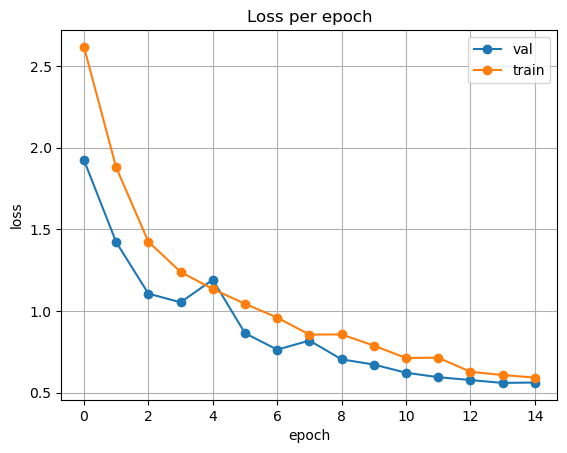

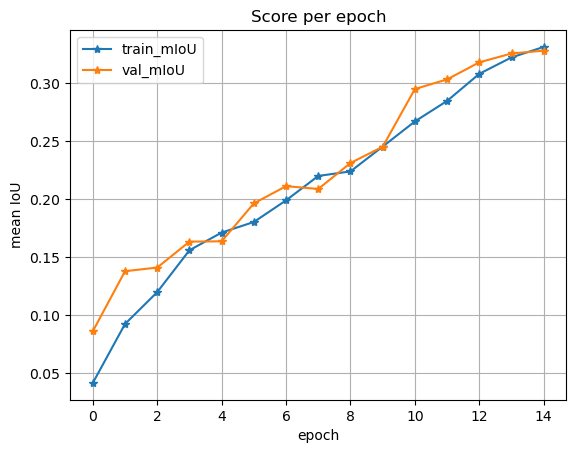

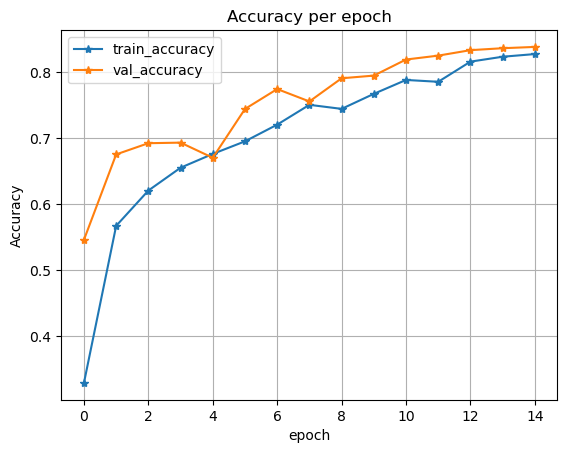

In [19]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [20]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [21]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [22]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [23]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [24]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [25]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [26]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [27]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

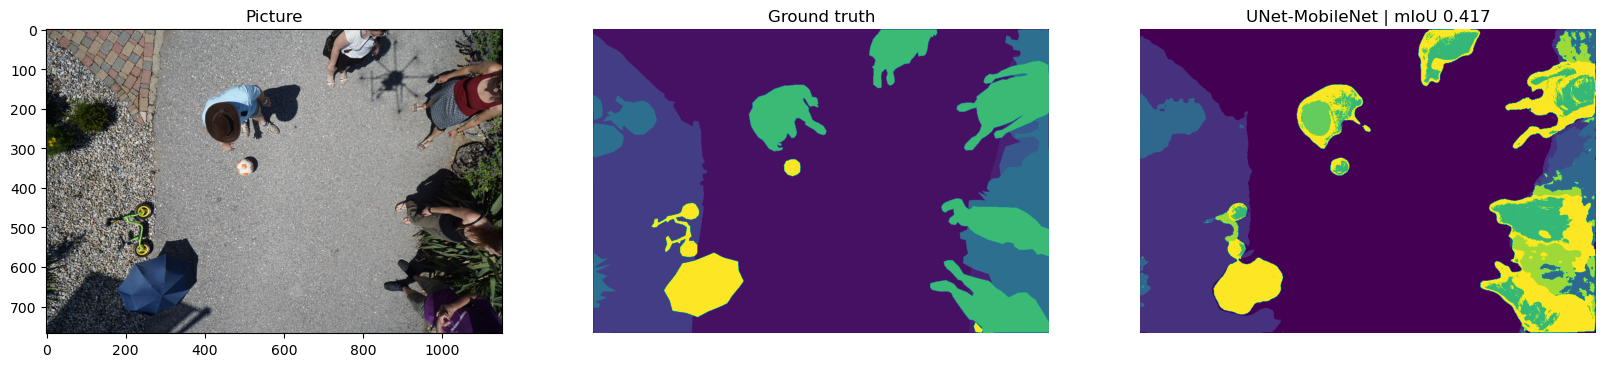

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

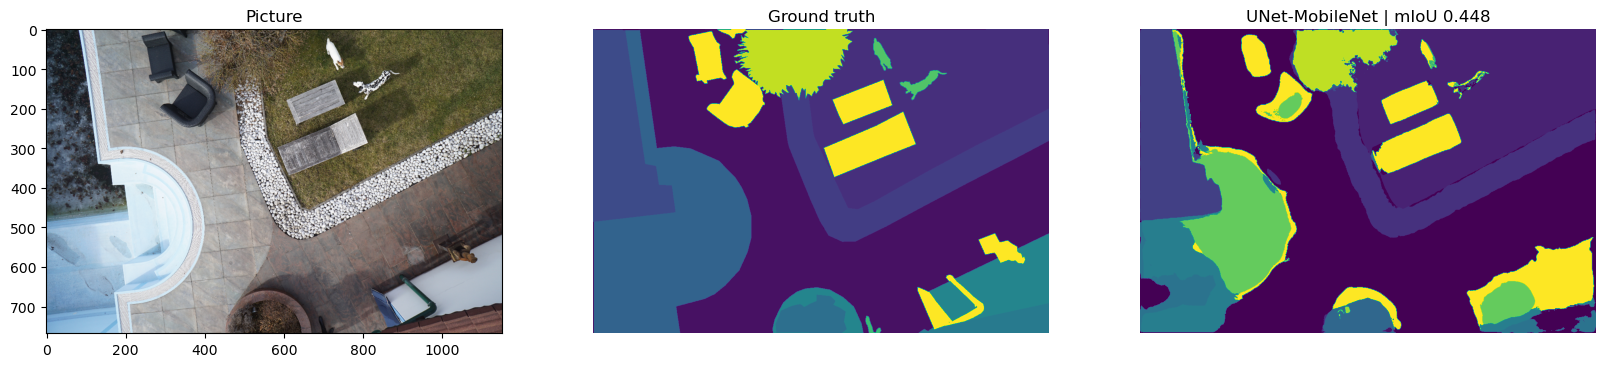

In [29]:
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

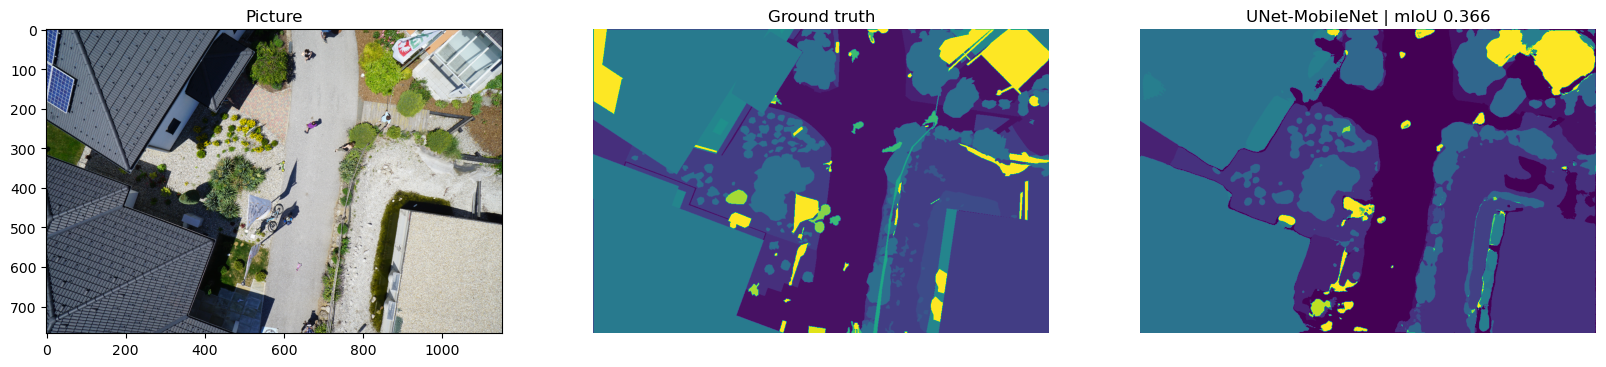

In [30]:
image3, mask3 = test_set[15]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [31]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.34946985321469926


In [32]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8187125594527632
